In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [2]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [3]:
def plot_res_S(link, init_type, optim_type, alpha, logS, track, k=0, scaling_factor=1, ax=None, title=True,
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3))
    i = 0

    print(alpha)
    track = np.array(track)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, k=k, scaling_factor=scaling_factor, track=track,
                    win=win,
                    L=L,
                    C=C,
                    emiter=emiter,
                    K=2)
    spikes = alpha_dict['spikes']
    S_true = alpha_dict['S']['true']
    S_oracle = alpha_dict['S']['oracle']
    S_naive = alpha_dict['S']['naive']
    S_init = alpha_dict['S']['init']

    S_true = S_true
    S_oracle = S_oracle
    S_init = S_init

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)
    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    # ax.plot(S_oracle, color='tab:green', label='direct')
    ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = alpha_dict['S']['model']
        ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        if logS is True:
            S_model = 10*np.log10(S_model)
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' f' = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = alpha_dict['S']['model']
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        # for i, c in enumerate(color):
        # plt.plot(x, y, c=c)
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=1.5, alpha=0.8)
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' + f' = {alpha}', fontweight='bold', fontsize=12)

    if logS is False:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([0,3000])

In [74]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, link, init_type, optim_type, scaling_factor=1, k=0, track=None,
                    win=1000,
                    L=49,
                    C=1,
                    emiter=20,
                    K=2
):
    fs = 1000
    delta = 1/fs
    seed = 8
    print()


    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    data_path = f'saved/synthetic_data/simple_latent_deltarelu_fixed_gamma_{K}_{L}_{sample_length}'
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    zs = latent['zs']
    xs = latent['xs']




    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])

    lams = cif_alpha_relu(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[k,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'

    model_load = pickle_open(model_path)
    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:49,k,k].real
    S_oracle = Gamma_zest[:49,k,k].real
    S_init = Gamma_init[:49,k,k].real

    S_true = S_true*scaling_factor
    S_oracle = S_oracle*scaling_factor
    S_init = S_init*scaling_factor

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:49]
    coh_true = thr_coherence(Gamma[:49,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:49,:,:])
    coh_init = thr_coherence(Gamma_init[:49,:,:])



    if track is not None:
        S_model = []
        coh_model = []

        for e in range(track[0], track[1]):
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:49,k,k].real
            S_model_itr = S_model_itr*scaling_factor
            coh_model_itr = thr_coherence(Gamma_est_itr[:49,:,:])

            S_model.append(S_model_itr)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:49,k,k].real
        S_model = S_model*scaling_factor
        coh_model = thr_coherence(Gamma_est[:49,:,:])

    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)

    return dict(coh=coh_dict, S=S_dict, spikes=spikes, lams=lams)



In [8]:
link = 'relu'
init_type = 'oracle'
optim_type = 'BFGS'
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2
scaling_factor = ((np.pi)/fs)*(np.pi/J)*(sample_length/J)
# scaling_factor = (delta**2)*(2*(np.pi**2))
# scaling_factor = (delta**2)*(2*(np.pi**2)*(1/fs)*(1/((sample_length/2)**2)))
# scaling_factor = (2*(np.pi**2/fs)*(sample_length/((sample_length/2)**2)))
# scaling_factor = (2*(np.pi)/fs)*(np.pi/J)*(sample_length/J)

# for init_type in ['flat', 'oracle']:
#     for optim_type in ['BFGS', 'Newton']:

#         alphas = [400, 600, 800, 1000]
#         logS = False
#         iters_show = [0,20]
#         fig, ax = plt.subplots(1,4,figsize=(18,3), sharey=True)
#         for a, alpha in enumerate(alphas):
#             alpha = float(alpha)
#             plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, ax=ax[a], k=1, scaling_factor=scaling_factor, title=False, emiter=20)
#             # plt.ylim([5000,9000])
#             ax[a].set_xlim([5,15])
#             ax[a].set_ylim([-5,2500])

#         fig.suptitle(f'{link}/{init_type}/{optim_type}; iters {iters_show[0]}-{iters_show[1]}', fontweight='bold', fontsize=12)
#         plt.tight_layout()


400.0



(5.0, 15.0)

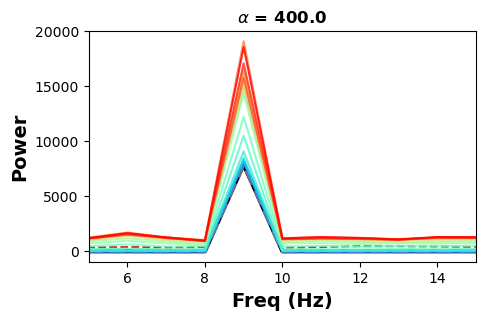

In [75]:
link = 'relu'
init_type = 'oracle'
optim_type = 'Newton'
alpha = 400.0
iters_show = [0,20]

plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, k=1, scaling_factor=scaling_factor, title=False, emiter=20)
# plt.ylim([5000,9000])
plt.xlim([5,15])



In [76]:
from cohlib.conv import conv_v_to_z
from cohlib.alg.em_sgc import get_trial_obj, compute_Gamma_real_logdet
K = 2
L = 50
em_iters = 20
seed = 8



C = 1
data_path = f'saved/synthetic_data/simple_latent_deltarelu_fixed_gamma_{K}_{L}_{sample_length}'
data_load = pickle_open(data_path)
model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
model_load = pickle_open(model_path)

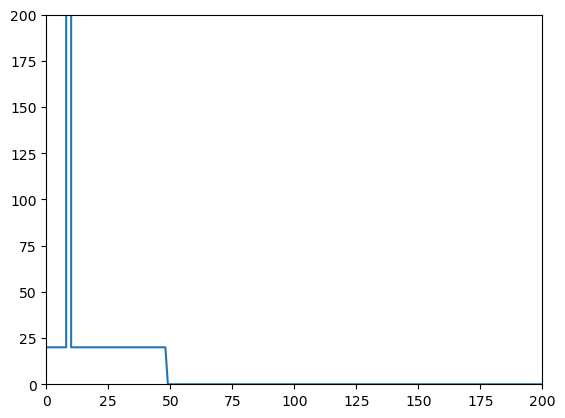

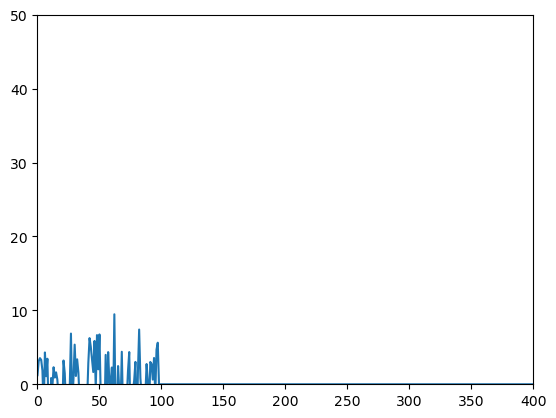

In [77]:

Gamma_new = data_load['latent']['Gamma']
vs_new = data_load['latent']['vs']
plt.plot(Gamma_new[:,0,0].real)
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()
plt.plot(vs_new[0,0,:].real)
plt.xlim([0,400])
plt.ylim([0,50])
plt.show()

In [122]:
from cohlib.alg.transform import construct_real_idft
def construct_real_idft_mod_Jsel(slen, J, J_list, fs, dc=False, order='standard'):
    Jv_list = []
    for j in J_list:
        Jv_list.append(2*(j-1))
        Jv_list.append(2*(j-1)+1)
    Jv_select = np.array(Jv_list)

    Jv_inds = np.arange(J*2)
    Jv_filt = np.zeros_like(Jv_inds).astype(bool)
    Jv_filt[Jv_select] = True

    Wv_full = construct_real_idft(slen, J, fs, dc, order=order)
    Wv_Js = Wv_full[:,Jv_filt]

    return Wv_Js

In [126]:
test = construct_real_idft_mod_Jsel(1000, 500, [10], fs)

In [104]:
J_list = [10,11]
Jv_list = []
for j in J_list:
    Jv_list.append(2*(j-1))
    Jv_list.append(2*(j-1)+1)
Jv_select = np.array(Jv_list)
Jv_inds = np.arange(J*2)
Jv_filt = np.zeros_like(Jv_inds).astype(bool)
Jv_filt[Jv_select] = True

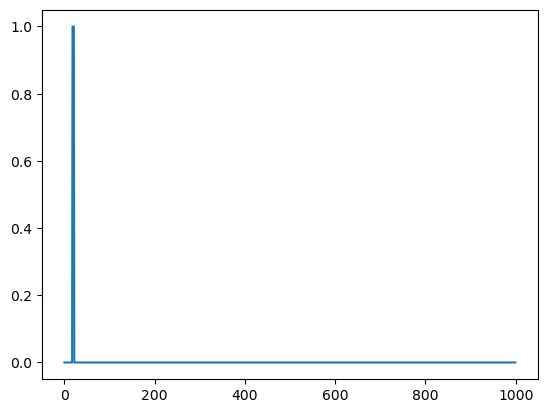

In [106]:
plt.plot(Jv_filt)

In [92]:
np.where(vs_new[0,0,:] < -25)

(array([18, 19]),)

(-100.0, 100.0)

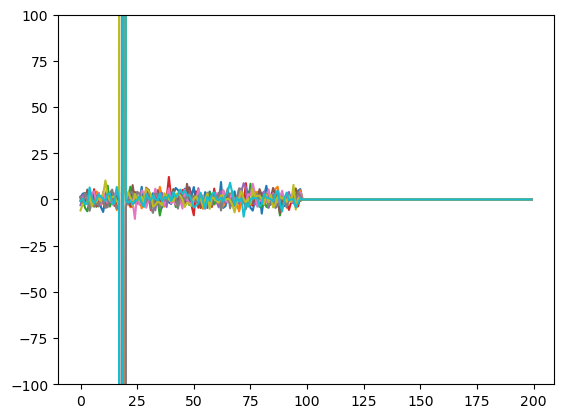

In [78]:
for l in range(10):
    plt.plot(vs_new[l,0,:200])
plt.ylim([-100,100])

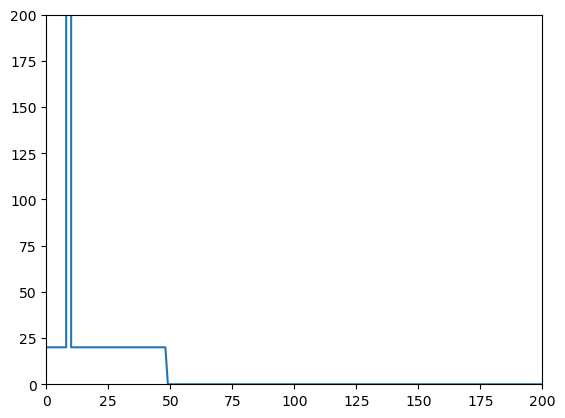

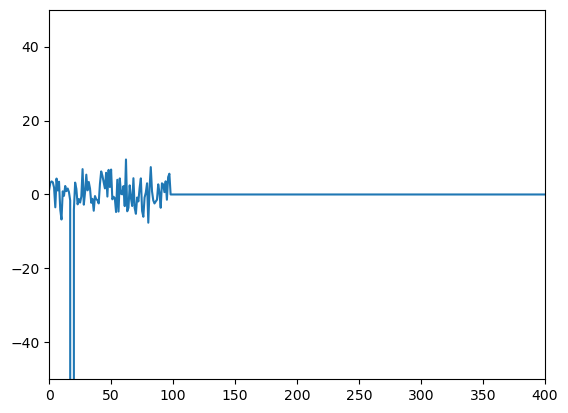

In [79]:
Gamma_old = data_load['latent']['Gamma']
vs_old = data_load['latent']['vs']
plt.plot(Gamma_old[:,0,0].real)
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()
plt.plot(vs_old[0,0,:].real)
plt.xlim([0,400])
plt.ylim([-50,50])
plt.show()

In [80]:
Gamma_true = data_load['latent']['Gamma']
zs = data_load['latent']['zs']
vs = data_load['latent']['vs']
xs = data_load['latent']['xs']



spikes = model_load['spikes']
spikes_grouped = [spikes[:,:,k,:] for k in range(K)]
data = spikes_grouped
Wv = model_load['Wv']
W = Wv
Gamma_inv_init = model_load['inv_init']

In [81]:
max_approx_iters = 50
num_J_vars = Wv.shape[1]
l = 0

params = [dict(alpha=alpha) for k in range(K)]
taper = None
obs_model = 'poisson-relu-delta'

Gamma_prev_inv = Gamma_inv_init
Gamma_init = deconstruct_Gamma_full_real(Gamma_inv_init, K, num_J_vars, invert=True)
Gamma_prev_real_logdet = compute_Gamma_real_logdet(Gamma_init)

mus = np.zeros((L, K * num_J_vars))
Ups_invs = np.zeros((L, K * num_J_vars, K * num_J_vars))
for l in range(L):
    trial = get_trial_obj(
        data, l, W, Gamma_prev_inv, params, taper=taper, obs_model=obs_model, optim_type=optim_type,
    Gamma_prev_logdet=Gamma_prev_real_logdet)
    mu, fisher_info = trial.laplace_approx(max_approx_iters)
    mus[l,:] = mu

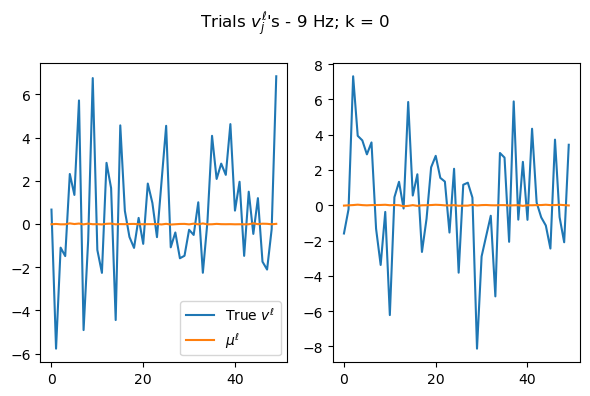

In [85]:
free_scale = True
k = 0

mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)

vs_k = vs[:,k,:num_J_vars]
vs_zk = conv_v_to_z(vs_k, axis=1, dc=False)

color = plt.cm.rainbow(np.linspace(0, 1, L))


j = 8
m1 = j*2
m2 = m1+1
fig, ax = plt.subplots(1,2,figsize=(6,4))
# fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(vs_k[:,m1], label='True $v^{\\ell}$')
ax[0].plot(mus[:,m1], label='$\\mu^{\\ell}$')
ax[0].legend()
ax[1].plot(vs_k[:,m2])
ax[1].plot(mus[:,m2])
fig.suptitle(f'Trials ' + '$v_j^{\\ell}$' + f'\'s - {j+1} Hz; k = {k}')
plt.tight_layout()

# fig, ax = plt.subplots(1,2,figsize=(8,4))
# ax[0].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
# ax[0].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
# ax[0].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

# ax[1].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
# ax[1].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
# ax[1].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

# lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
# for i in range(2):
#     ax[i].set_xlabel('Real')
#     ax[i].set_xlabel('Imag')
# if free_scale is False:
#     ax[0].set_xlim([-lim,lim])
#     ax[0].set_ylim([-lim,lim])
# plt.tight_layout()
# plt.show()

-0.01981082153770092

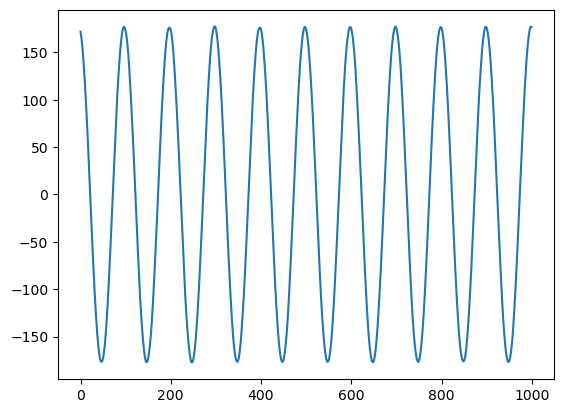

In [68]:
plt.plot(xs[0,0,:])
xs[:,:,:].mean()

In [79]:
np.where(np.abs(vs[0,0,:]) > 25)

(array([18, 19]),)

In [15]:
mags = np.abs(zs[0,0,:])
np.where(mags > 24)


(array([9]),)

(0.0, 30.0)

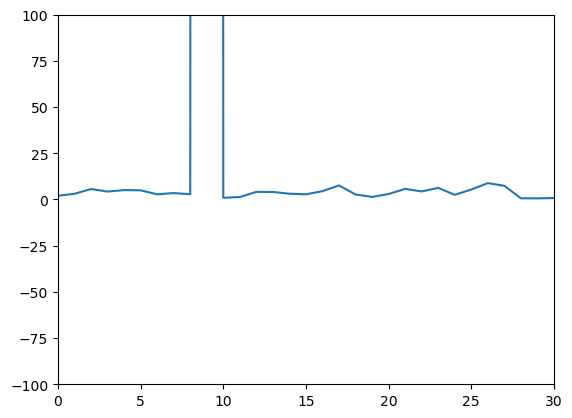

In [16]:
plt.plot(np.abs(zs[0,0,:]))
plt.ylim([-100,100])
plt.xlim([0,30])

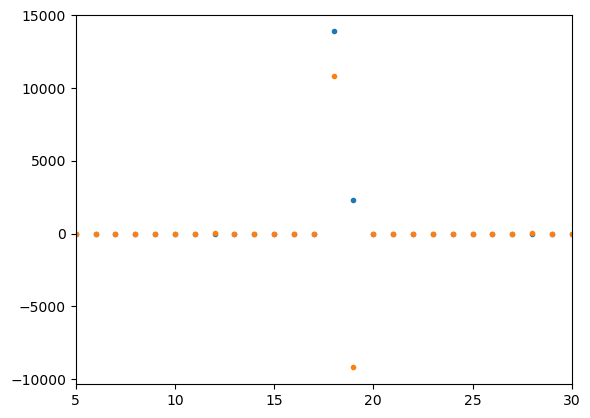

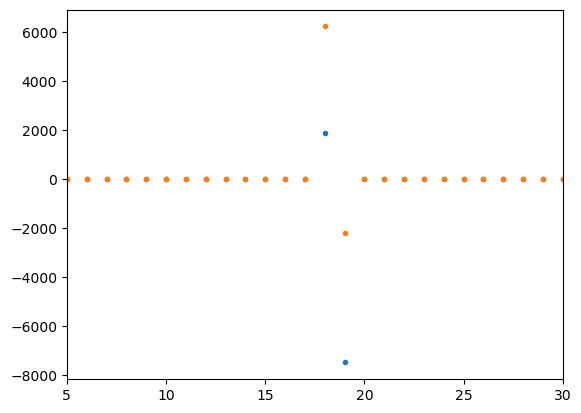

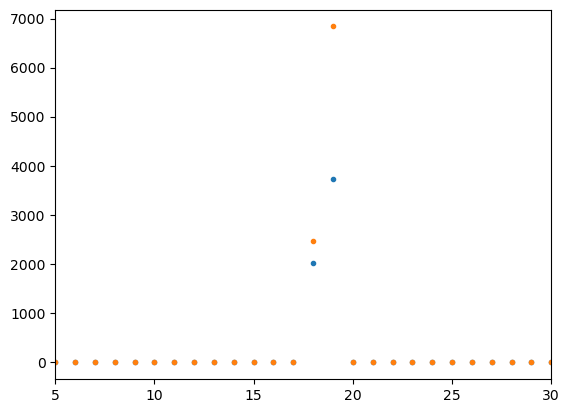

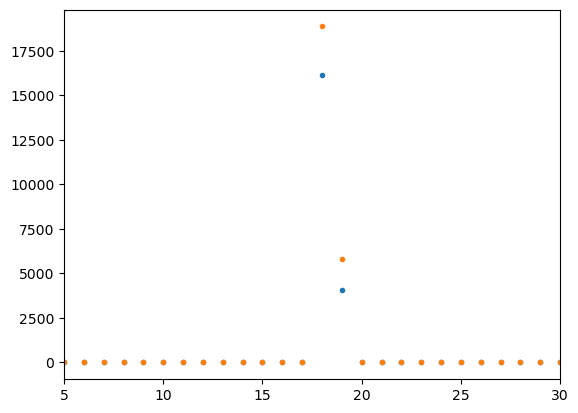

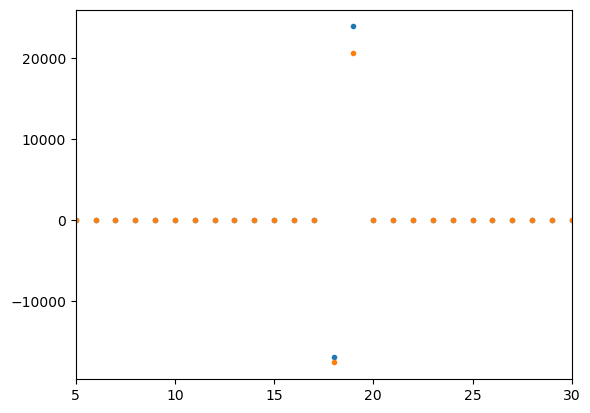

In [20]:
for l in range(5):
    plt.plot(vs[l,0,:], '.')
    plt.plot(vs[l,1,:], '.')
    # plt.ylim([-100,100])
    plt.xlim([5,30])
    plt.show()

In [23]:
num_J_vars

98

In [30]:
vs_k = vs[:,k,:num_J_vars]
mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]

In [38]:
l = 0

In [ ]:
r = 19
k = 0
# for r in range(20):
#     mus = model_load['track'][0][r]['mus']
#     mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
#     # plt.plot(mus_zk.mean(0).real)
#     np.abs(mus_zk.mean(0))**2
#     plt.plot(np.abs(mus_zk.mean(0))**2)
j = 9
K = 2

stitr = 5
enditr = stitr+5

free_scale = False

fig, ax = plt.subplots(2,5,figsize=(18,6))
for i, r in enumerate(range(enditr, stitr, -1)):
    i = 4-i
    for k in range(K):
        mus = model_load['track'][0][r]['mus']
        mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
        mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
        color = plt.cm.rainbow(np.linspace(0, 1, L))

        ax[k,i].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
        ax[k,i].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
        # ak,x[i].set_title(r'$z_{j=5}$', f'; em-iter {r+1}')
        ax[k,i].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}; em-iter {r+1}')
        ax[k,i].set_xlabel('Real')
        ax[k,i].set_xlabel('Imag')
        if i == 4:
            print('ping')
            lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
        if free_scale is False:
            ax[k,i].set_xlim([-lim,lim])
            ax[k,i].set_ylim([-lim,lim])
plt.tight_layout()
plt.show()


# mus.shape
# for l in range(L):
#     mu_l = mus[l,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mu_zl = conv_v_to_z(mu_l, axis=0, dc=False)
#     plt.plot(np.abs(mu_zl))